## **NOC Near-Present Day Hackathon**
### Tutorial 0. Getting Started with xarray for Ocean Science

#### **Contact:**
Ollie Tooth (oliver.tooth@noc.ac.uk)

#### **Background:**
---

Ocean models produce large, multi-dimensional fields (e.g. temperature, salinity, velocity) that vary in time and space and are described by physical coordinates (e.g., depth). Additionally, scalar and vector output variables are often stored on different, staggered model grids (e.g., Arakawa A-, B-, C-grids), meaning that we must often transform variables prior to performing any computations.

[**xarray**](https://docs.xarray.dev/en/stable/) is an open-source Python library which provides data structures that explicitly represent the physical coordinates, rather than treating model outputs as anonymous multi-dimensional arrays. In practice, this means we can perform dimension-aware computations using dimension labels, such as `time`, `depth`, etc., which automatically align variables stored on the same grid or sharing the same time dimension.

This Tutorial provides an introduction to xarray for ocean model analysis and is intended as a quick reference that you can return to during the hackathon and beyond.

We will cover:

* How to...

#### **1.1 Basics**
---

**xarray** extends the NumPy and pandas Python libraries to handle *labelled, multi-dimensional arrays*.

**Fundamental Ideas:**
* Each dimensions has a name (e.g., "time", "depth", "lat", "lon").
* Coordinates are attached to dimensions (e.g., depth values in meters).
* Metadata (units, long_name, etc.) are preserved.

**Key advantages:**
* Labelled dimensions → No guessing axis order.
* Automatic alignment & broadcasting → Safer calculations.
* Lazy loading + Dask support → scalable to large datasets O(TBs).
* Seamless reading & writing of NetCDF files
* Integrated plotting features

**Core Data Structures:**
* DataArray: a single variable + coordinates + attributes
* Dataset: a collection of DataArrays sharing coordinates
* DataTree: a tree-like hierarchical collection of xarray DataArray or Dataset objects.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

#### **1.2 Opening a Dataset**
---

**xarray** includes several example datasets.

Here, we will use the NOAA Extended Reconstructed global Sea Surface Temperature (**SST**) monthly averages dataset.

This is similar in structure to typical ocean model surface output:
- **Dimensions**: `time` × `lat` × `lon`
- **Variable**: `sst`
- Includes metadata and coordinates

In [2]:
ds = xr.tutorial.load_dataset("ersstv5")
ds

<xarray.Dataset> Size: 40MB
Dimensions:    (time: 624, nbnds: 2, lat: 89, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2021-12-01
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 10kB 9.969e+36 9.969e+36 ... 9.969e+36
    sst        (time, lat, lon) float32 40MB -1.8 -1.8 -1.8 -1.8 ... nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

In [3]:
# Inspect dimensions, coordinates, variables
print(ds.dims)
print(ds.coords)
print(ds.data_vars)

FrozenMappingWarningOnValuesAccess({'time': 624, 'nbnds': 2, 'lat': 89, 'lon': 180})
Coordinates:
  * time     (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2021-12-01
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Data variables:
    time_bnds  (time, nbnds) float64 10kB 9.969e+36 9.969e+36 ... 9.969e+36
    sst        (time, lat, lon) float32 40MB -1.8 -1.8 -1.8 -1.8 ... nan nan nan


#### **1.3 Dataset & DataArray**
---

**xarray** has two core data structures:

**Dataset**
- Container of multiple variables stored as DataArrays
- Similar to a NetCDF file in memory

**DataArray**
- Single N-dimensional variable
- Contains:
  - data
  - dimensions
  - coordinates
  - attributes

In [4]:
sst = ds["sst"]

sst.dims, sst.shape

(('time', 'lat', 'lon'), (624, 89, 180))

In [5]:
sst.coords

Coordinates:
  * time     (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2021-12-01
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0

In [6]:
sst.attrs

{'long_name': 'Monthly Means of Sea Surface Temperature',
 'units': 'degC',
 'var_desc': 'Sea Surface Temperature',
 'level_desc': 'Surface',
 'statistic': 'Mean',
 'dataset': 'NOAA Extended Reconstructed SST V5',
 'parent_stat': 'Individual Values',
 'actual_range': array([-1.8    , 42.32636], dtype=float32),
 'valid_range': array([-1.8, 45. ], dtype=float32)}

#### **0.4 Indexing & Selection**
---

**Indexing (NumPy-style)**
- Uses integer positions
- Fragile if dimension order changes

**Selection (xarray-style)**
- Uses **dimension names**
- Safer and more readable


In [7]:
sst.isel(time=0)

<xarray.DataArray 'sst' (lat: 89, lon: 180)> Size: 64kB
array([[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]],
      shape=(89, 180), dtype=float32)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    time     datetime64[ns] 8B 1970-01-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [8]:
sst.sel(time="1990-01-01")

<xarray.DataArray 'sst' (lat: 89, lon: 180)> Size: 64kB
array([[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]],
      shape=(89, 180), dtype=float32)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    time     datetime64[ns] 8B 1990-01-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [9]:
sst.sel(lat=slice(-30, 30), lon=slice(120, 280))

<xarray.DataArray 'sst' (time: 624, lat: 0, lon: 81)> Size: 0B
array([], shape=(624, 0, 81), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2021-12-01
  * lat      (lat) float32 0B 
  * lon      (lon) float32 324B 120.0 122.0 124.0 126.0 ... 276.0 278.0 280.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

#### **0.4.1 Spatial Subsetting**

Example: Tropical Pacific SSTs

In [10]:
trop_pac = sst.sel(
    lat=slice(-10, 10),
    lon=slice(160, 260)
)

trop_pac

<xarray.DataArray 'sst' (time: 624, lat: 0, lon: 51)> Size: 0B
array([], shape=(624, 0, 51), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2021-12-01
  * lat      (lat) float32 0B 
  * lon      (lon) float32 204B 160.0 162.0 164.0 166.0 ... 256.0 258.0 260.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

#### **0.5 Plotting**
---

**xarray** integrates with matplotlib for fast visualisation.

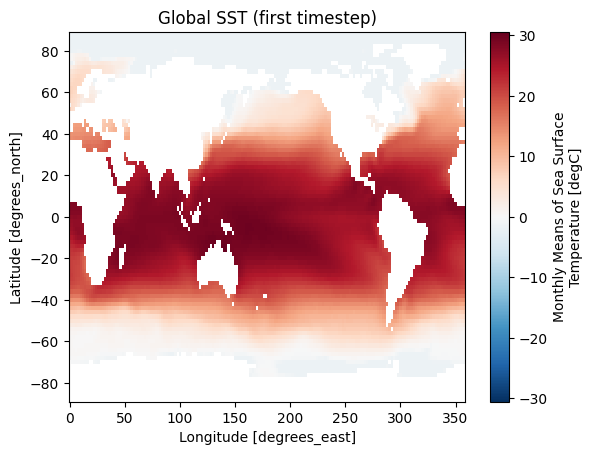

In [11]:
sst.isel(time=0).plot()
plt.title("Global SST (first timestep)")
plt.show()


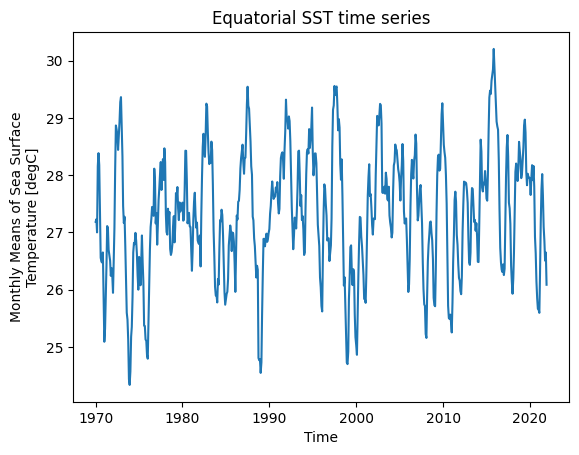

In [12]:
sst_eq = sst.sel(lat=0, lon=200, method="nearest")
sst_eq.plot()
plt.title("Equatorial SST time series")
plt.show()


#### **0.6 Core Operations**
---

#### **0.6.1 Reduction Operations**

Common ocean diagnostics:
- Mean SST
- Zonal or meridional averages
- Time averages

**xarray** reductions explicitly name dimensions.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


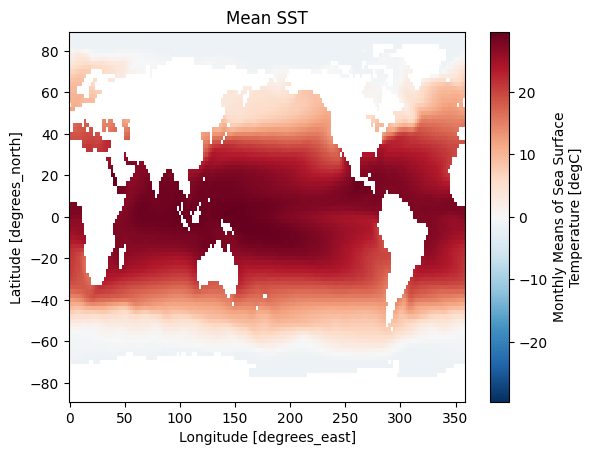

In [13]:
sst_mean = sst.mean(dim="time")
sst_mean.plot()
plt.title("Mean SST")
plt.show()

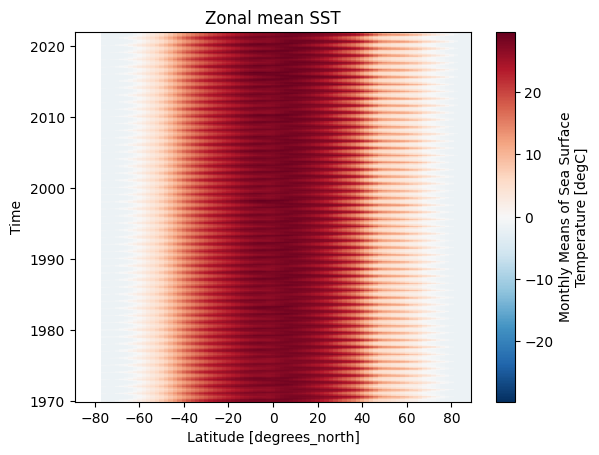

In [14]:
sst_zonal = sst.mean(dim="lon")
sst_zonal.plot()
plt.title("Zonal mean SST")
plt.show()

#### **0.6.2 Group-By Operations**

Group-By is essential for:
- Seasonal cycles
- Climatologies
- Anomaly calculations

In [15]:
sst_clim = sst.groupby("time.month").mean(dim="time")
sst_clim

<xarray.DataArray 'sst' (month: 12, lat: 89, lon: 180)> Size: 769kB
array([[[-1.8000005, -1.8000005, -1.8000005, ..., -1.8000005,
         -1.8000005, -1.8000005],
        [-1.8000005, -1.8000005, -1.8000005, ..., -1.8000005,
         -1.8000005, -1.8000005],
        [-1.8000005, -1.8000005, -1.8000005, ..., -1.8000005,
         -1.8000005, -1.8000005],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.8000005, -1.8000005, -1.8000005, ..., -1.8000005,
         -1.8000005, -1.8000005],
        [-1.8000005, -1.8000005, -1.8000005, ..., -1.8000005,
         -1.8000005, -1.8000005],
        [-1.8000005, -1.8000005, -1.8000005, ..., -1.8000005,
         -1.8000005, -1.8000005],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.7994802, -1.7995852, -1.7998399, ..., -1.7997632,
         -1.7996233, -1.7994753],
        [-1.7995453, -1.7997496, -1.8000005, ..., -1.8000005,
         -1.799799 , -1.7995732],
        [-1.8000005, -1.8000005, -1.8000005, ..., -1.8000005,
         -1.8000005, -1.8000005],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], shape=(12, 89, 180), dtype=float32)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

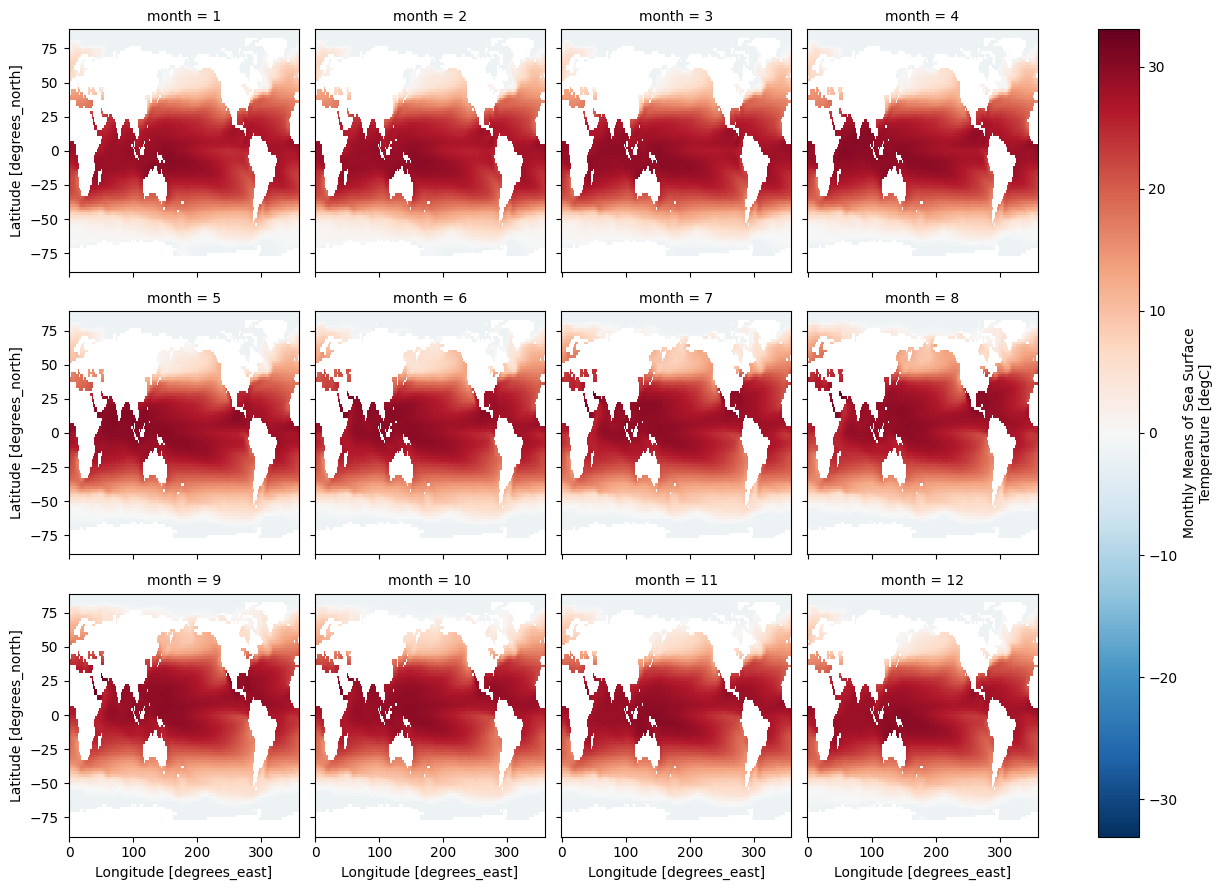

In [16]:
sst_clim.plot(col="month", col_wrap=4)
plt.show()

In [17]:
sst_anom = sst.groupby("time.month") - sst_clim
sst_anom

<xarray.DataArray 'sst' (time: 624, lat: 89, lon: 180)> Size: 40MB
array([[[ 5.96046448e-07,  5.96046448e-07,  5.96046448e-07, ...,
          5.96046448e-07,  5.96046448e-07,  5.96046448e-07],
        [ 5.96046448e-07,  5.96046448e-07,  5.96046448e-07, ...,
          5.96046448e-07,  5.96046448e-07,  5.96046448e-07],
        [ 5.96046448e-07,  5.96046448e-07,  5.96046448e-07, ...,
          5.96046448e-07,  5.96046448e-07,  5.96046448e-07],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 5.96046448e-07,  5.96046448e-07,  5.96046448e-07, ...,
          5.96046448e-07,  5.96046448e-07,  5.96046448e-07],
        [ 5.96046448e-07,  5.96046448e-07,  5.96046448e-07, ...,
          5.96046448e-07,  5.96046448e-07,  5.96046448e-07],
        [ 5.96046448e-07,  5.96046448e-07,  5.96046448e-07, ...,
          5.96046448e-07,  5.96046448e-07,  5.96046448e-07],
...
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-5.19752502e-04, -4.14729118e-04, -1.60098076e-04, ...,
         -2.36749649e-04, -3.76701355e-04, -5.24640083e-04],
        [-4.54664230e-04, -2.50339508e-04,  5.96046448e-07, ...,
          5.96046448e-07, -2.00986862e-04, -4.26769257e-04],
        [ 5.96046448e-07,  5.96046448e-07,  5.96046448e-07, ...,
          5.96046448e-07,  5.96046448e-07,  5.96046448e-07],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]],
      shape=(624, 89, 180), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2021-12-01
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    month    (time) int64 5kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]